# CIS 600: Internet of Things: Security and Privacy
> Authors: mshirani, gsarraf, schava03, jpatel25

### CAN Bus Intrusion Detection System using Machine Learning

In [19]:
# Importing required libraries
import pandas as pd
import csv
import os

In [20]:
# Defining a function to read the dataset
def process_file(input_file_name, dataset_type, combined_data):
    with open(input_file_name, 'r') as infile:
        for line in infile:
            parts = line.split()
            if len(parts) < 8:
                continue

            timestamp = parts[1] if len(parts) > 1 else ''
            try:
                id_index = parts.index('ID:') + 1
                id_ = parts[id_index] if len(parts) > id_index else ''
                dlc_index = parts.index('DLC:') + 1
                dlc = parts[dlc_index] if len(parts) > dlc_index else ''
                data_index = dlc_index + 1
                data = ' '.join(parts[data_index:]) if len(parts) > data_index else ''
            except ValueError:
                continue

            if dataset_type == 'DoS_attack_dataset.txt' and id_ == '000':
                label = 'malicious'
            elif dataset_type in ['Fuzzy_attack_dataset.txt', 'Impersonation_attack_dataset.txt'] and float(timestamp) >= 250:
                label = 'malicious'
            else:
                label = 'benign'

            combined_data.append([timestamp, id_, dlc, data, label])

In [21]:
output_file_name = 'combined_dataset_labeled.csv'

# Checking if the combined dataset already exists
if not os.path.exists('combined_dataset_labeled.csv'):
    datasets = ['Attack_free_dataset.txt', 'DoS_attack_dataset.txt', 'Fuzzy_attack_dataset.txt', 'Impersonation_attack_dataset.txt']
    combined_data = []

    for file_name in datasets:
        file_name = file_name
        process_file(file_name, file_name, combined_data)

    with open(output_file_name, 'w', newline='') as outfile:
        writer = csv.writer(outfile)
        writer.writerow(['Timestamp', 'ID', 'DLC', 'Data', 'Label'])
        writer.writerows(combined_data)

    print(f"Combined dataset saved to '{output_file_name}'.")
else:
    print(f"Combined dataset found '{output_file_name}'.")

Combined dataset found 'combined_dataset_labeled.csv'.


In [22]:
# Loading the combined dataset into a dataframe
df = pd.read_csv(output_file_name)

In [23]:
len(df)

4489685

In [24]:
# Look at the first few samples
df.head()

,Timestamp,ID,DLC,Data,Label
0,0.000000,0316,8,05 20 ea 0a 20 1a 00 7f,benign
1,0.000224,0329,8,d7 a7 7f 8c 11 2f 00 10,benign
2,0.000462,0080,8,00 17 ea 0a 20 1a 20 43,benign
3,0.000704,0081,8,7f 84 60 00 00 00 00 53,benign
4,0.000878,0120,4,00 00 00 00,benign


<Axes: title={'center': 'Number of Samples for Each Class'}>

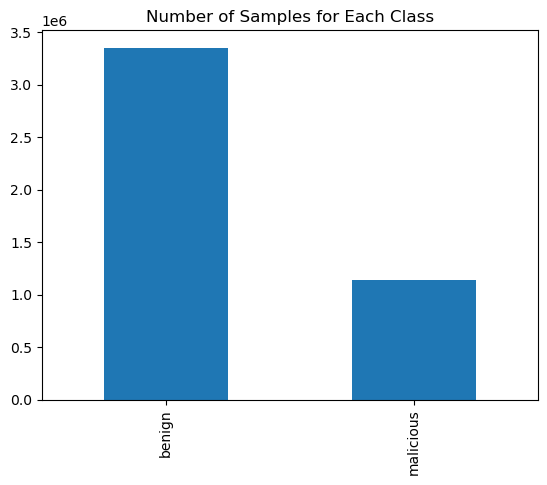

In [25]:
# Plot the number of samples for each class
df['Label'].value_counts().plot(kind='bar', title='Number of Samples for Each Class')

In [26]:
# See the datatypes of each column
df.dtypes

Timestamp    float64
ID            object
DLC            int64
Data          object
Label         object
dtype: object

In [27]:
# Map the label column to 0 and 1
df['Label'] = df['Label'].map({'benign': 0, 'malicious': 1})

In [28]:
# Check for any NaN or missing values in the dataset
df.isnull().sum()

Timestamp    0
ID           0
DLC          0
Data         0
Label        0
dtype: int64

In [29]:
# Convert the hex data to decimal and save into 8 different columns
for i in range(8):
    df[f'Data_{i}'] = df['Data'].apply(lambda x: int(x.split()[i], 16) if len(x.split()) > i else 0)

# Process the timestamp column to get the time difference between each packet
df['Timestamp'] = pd.to_numeric(df['Timestamp'])
df['Time_Interval'] = df['Timestamp'].diff().fillna(0)

# Convert the time interval to milliseconds
df['Time_Interval'] = df['Time_Interval'] * 1000

# Convert IDs to numeric values
df['ID'] = pd.to_numeric(df['ID'], errors='coerce')

# Drop the unnecessary columns
df.drop(['Timestamp', 'Data'], axis=1, inplace=True)

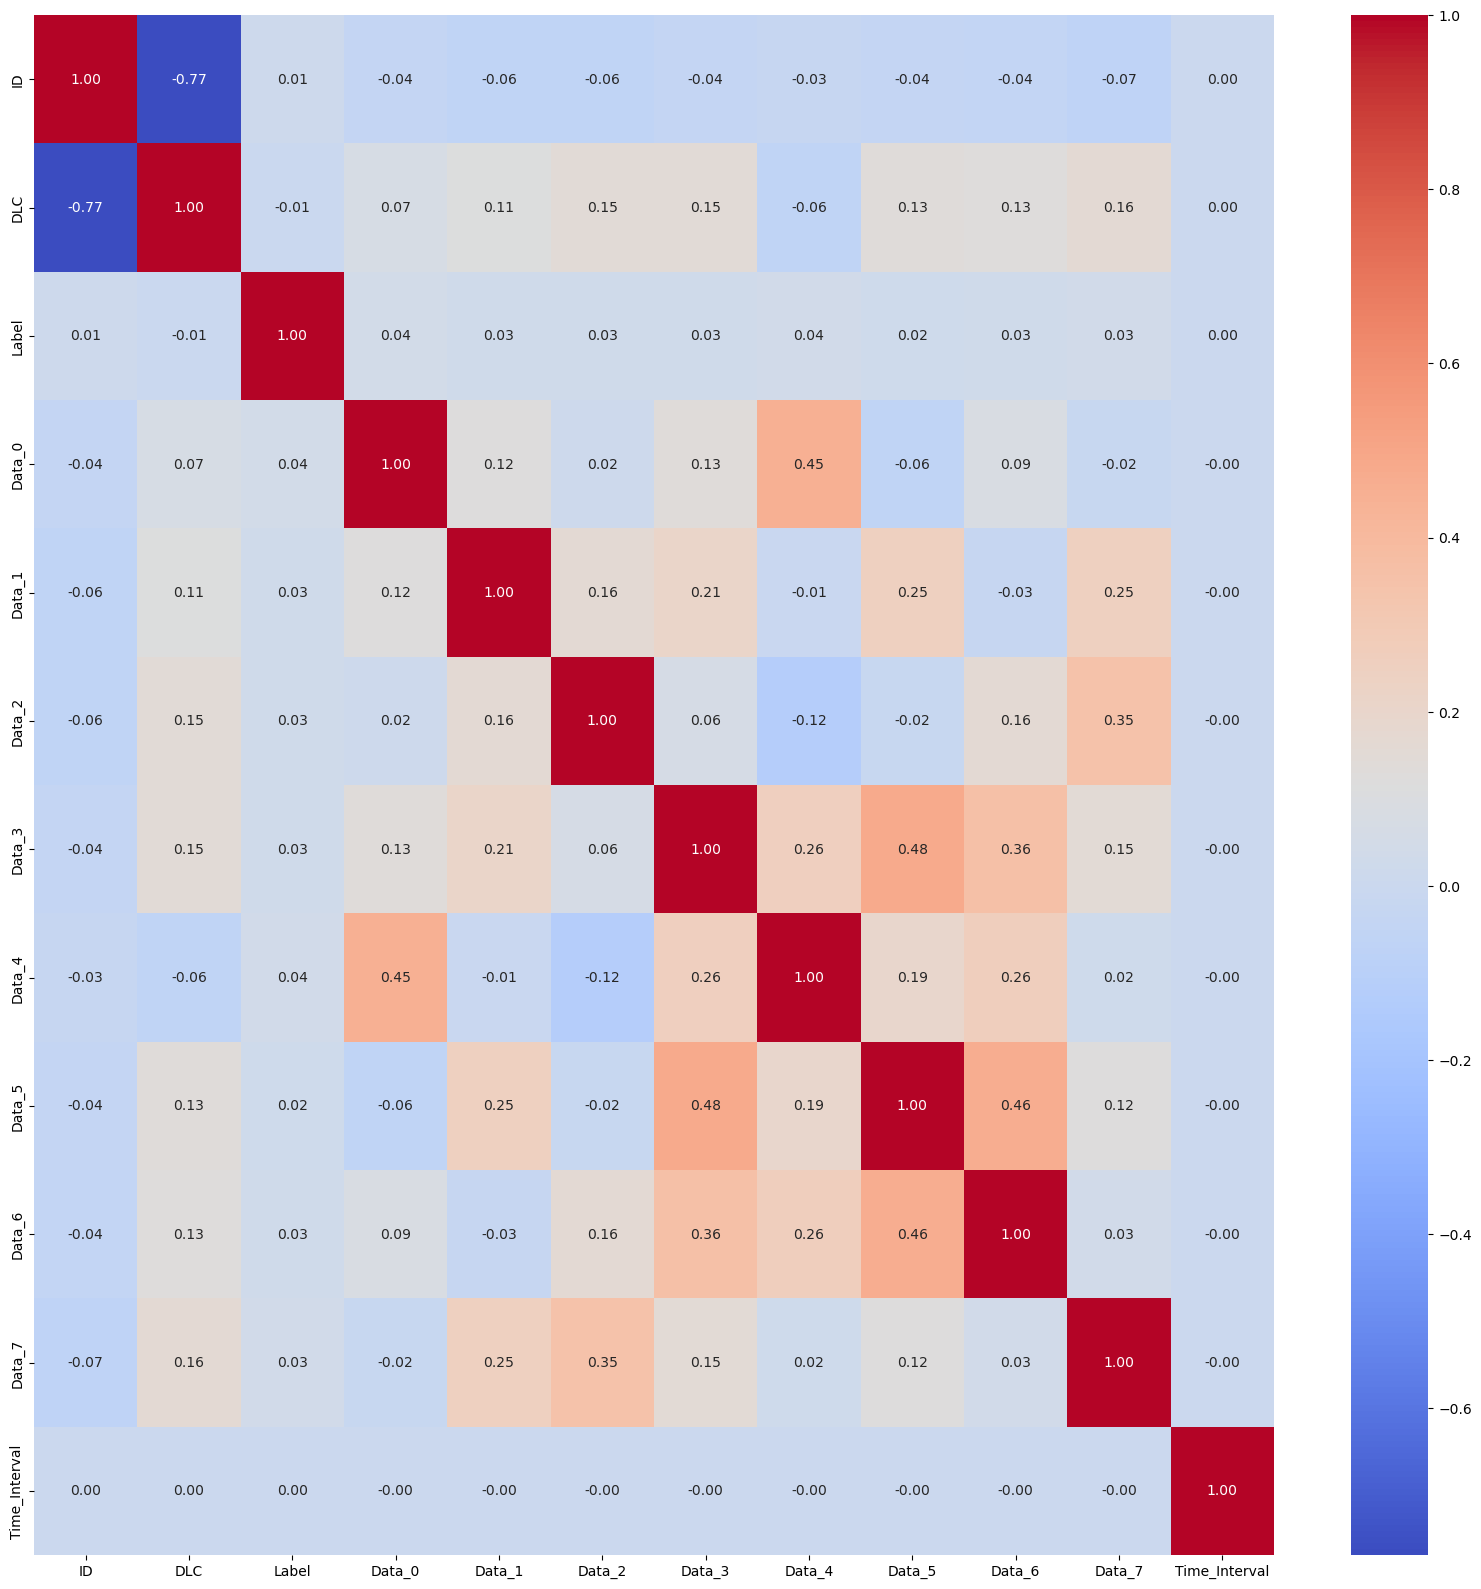

In [30]:
# Plor a correlation matrix to see the correlation between different features
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(20, 20))
sns.heatmap(df.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.show()

In [31]:
df.head()

,ID,DLC,Label,Data_0,Data_1,Data_2,Data_3,Data_4,Data_5,Data_6,Data_7,Time_Interval
0,316.0,8,0,5,32,234,10,32,26,0,127,0.000
1,329.0,8,0,215,167,127,140,17,47,0,16,0.224
2,80.0,8,0,0,23,234,10,32,26,32,67,0.238
3,81.0,8,0,127,132,96,0,0,0,0,83,0.242
4,120.0,4,0,0,0,0,0,0,0,0,0,0.174


In [32]:
# Add statistical features to the dataset
for i in range(8):
    df[f'Mean_Data_{i}'] = df[f'Data_{i}'].rolling(window=5).mean().fillna(0) # Mean
    df[f'Std_Data_{i}'] = df[f'Data_{i}'].rolling(window=5).std().fillna(0) # Standard Deviation
    
# Creating some derived features
df['ID'] = df['ID'].rolling(window=10).sum().fillna(0)

# Look at the first few samples
df.head()

,ID,DLC,Label,Data_0,Data_1,Data_2,Data_3,Data_4,Data_5,Data_6,...,Mean_Data_3,Std_Data_3,Mean_Data_4,Std_Data_4,Mean_Data_5,Std_Data_5,Mean_Data_6,Std_Data_6,Mean_Data_7,Std_Data_7
0,0.0,8,0,5,32,234,10,32,26,0,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000
1,0.0,8,0,215,167,127,140,17,47,0,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000
2,0.0,8,0,0,23,234,10,32,26,32,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000
3,0.0,8,0,127,132,96,0,0,0,0,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000
4,0.0,4,0,0,0,0,0,0,0,0,...,32.0,60.580525,16.2,16.006249,19.8,20.004999,6.4,14.310835,58.6,51.461636


Accuracy: 0.9315144766146993


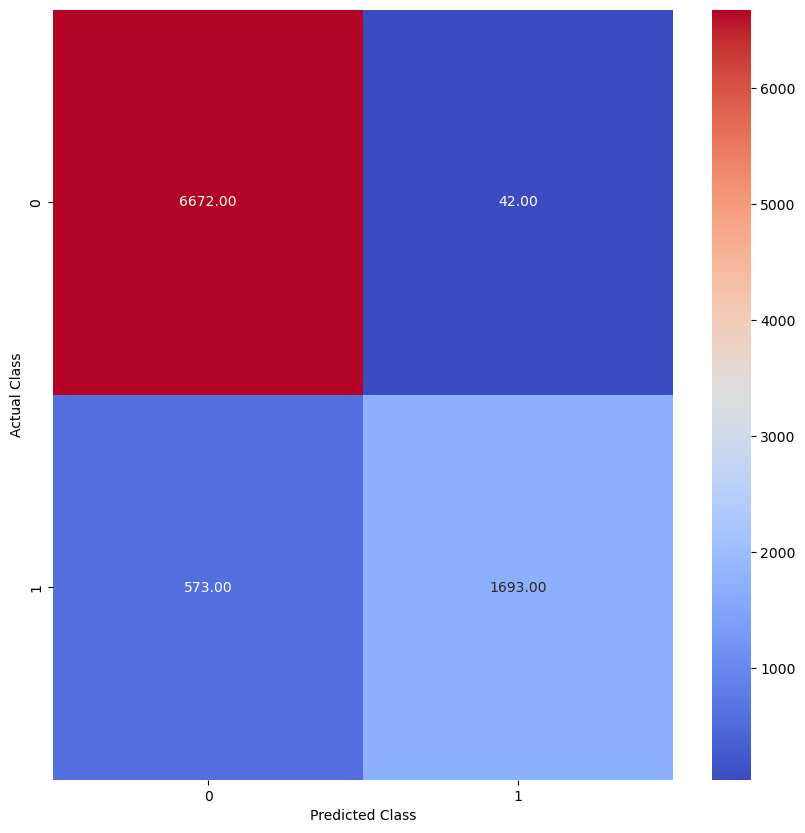

In [33]:
# Let's train a machine learning model to classify the data
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Split the dataset into train and test sets
df = df.sample(frac=0.01, random_state=42)
X = df.drop(['Label'], axis=1)
y = df['Label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest Classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = clf.predict(X_test)

# Calculate the accuracy of the model
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")

# Plot the confusion matrix
plt.figure(figsize=(10, 10))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='.2f', cmap='coolwarm')
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
plt.show()

In [34]:
# Print the classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.99      0.96      6714
           1       0.98      0.75      0.85      2266

    accuracy                           0.93      8980
   macro avg       0.95      0.87      0.90      8980
weighted avg       0.93      0.93      0.93      8980



In [35]:
test_output = pd.DataFrame(clf.predict(X_test), index = X_test.index, columns = ['Predicted_Label']) 
test_output = test_output.merge(y_test, left_index = True, right_index = True) 
mean_absolute_error = abs(test_output['Predicted_Label'] - test_output\
                          ['Label']).mean()
print('Mean absolute error is ')
print(mean_absolute_error)

Mean absolute error is 
0.06848552338530067
